# 모델 설정

```Python
MSL = 100
NUM_CLASS = 50
SZ_WORD_VOCAB = 51459
DIM_EMBEDDING = 100
SZ_HIDDEN_STATE = 128
NUM_HIDDEN_LAYERS = 2
BATCH_SIZE = 256
```

코랩 유료 컴퓨팅 리소스를 구매해 신나서 히든 레이어 수를 40개로 늘리고 히든 스테이트 상태도 256개로 늘려보았으나 성능이 10%대로 매우 낮았다. 이는 데이터가 가진 정보에 비해 모델의 크기가 너무 커서 정보가 제대로 역전파되지 못하는 그레디언트 소실(Gradient Vanishing) 문제가 발생했기 때문으로 풀이된다.

```Python
# 양방향 LSTM 위에 3개의 FF 층을 올린다.
class POS_model(nn.Module):
    def __init__(self, token_vocab_size, dim_embedding, num_hidden_layers, hidden_state_size):
        super(POS_model, self).__init__()
        self.embedding = nn.Embedding(token_vocab_size, dim_embedding, padding_idx=0)

        self.lstm = nn.LSTM(input_size=dim_embedding, hidden_size=hidden_state_size,
                            num_layers=num_hidden_layers, batch_first=True, bidirectional=True)

        self.linear1 = nn.Linear(2*hidden_state_size, 512, bias=True)
        self.relu = nn.ReLU()

        self.linear2 = nn.Linear(512, 256, bias=True)

        self.linear3 = nn.Linear(256, NUM_CLASS)    # NUM_CLASS is the number of classes of POS

    def forward(self, X):
        # X: shape (batch, msl) where each example is a list of token ids of length msl.
        x1 = self.embedding(X)     # output shape is (batch, msl, dim_embedding)

        x2, _ = self.lstm(x1)      # LSTM을 3계 시퀀스로 통과한 상태
        # x2의 형태는 2계 방향이 추가된 최종 상태: (batch, MSL, hidden_state)

        x3 = self.linear1(x2)      # FF3 : output shape is (batch, msl, 512).
        x4 = self.relu(x3)

        x5 = self.linear2(x4)      # FF3 : output shape is (batch, msl, 256).
        x6 = self.relu(x5)

        x7 = self.linear3(x6)      # FF3 : output shape is (batch, msl, num_class).
        return x7
```

# 실험 결과

컴퓨팅 리소스와 페이즈 크기 문제로 모든 에포크마다 성능을 출력하게 하진 않고 10 에포크마다 출력하게 하였다. 그리고 그중에서 성능이 더 좋은 모델이 있으면 자동으로 저장하게 코딩하였다.

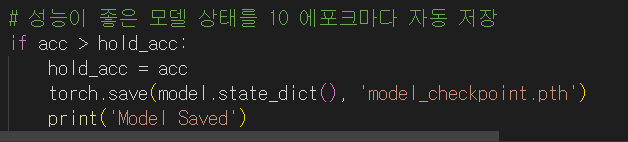

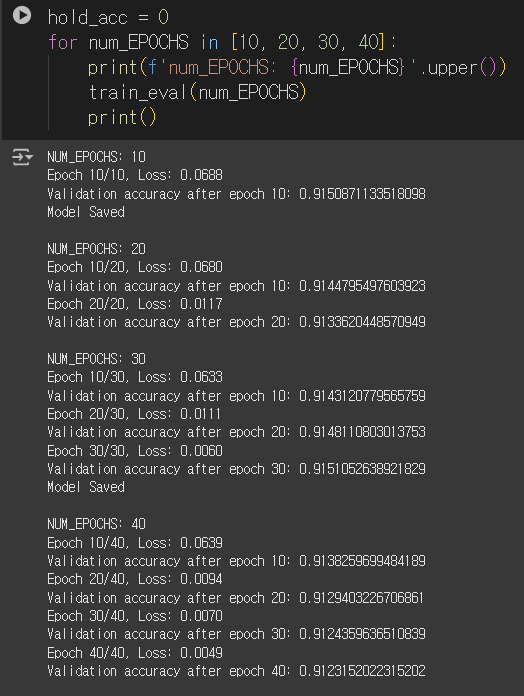

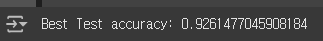

세 번쨰 실험에서의 30 epochs 동안 훈련시킨 모델이 약 91.5105%의 정확도로 최고 성능을 보였다. 평가 데이터에서도 정확도가 약 92.6148%로 일반화 성능도 괜찮았다.